# Examplary office Chilled Water consumption prediction usning LSTM Model

Energy consumption forecasting for buildings has immense value in energy efficiency and sustainability research. Accurate energy forecasting models have numerous implications in planning and energy optimization of buildings and campuses. For new buildings, where past recorded data is unavailable, computer simulation methods are used for energy analysis and forecasting future scenarios. However, for existing buildings with historically recorded time series energy data, statistical and machine learning techniques have proved to be more accurate and quick

## Imports

In [2]:
# Data analysis packages:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f'%x)

import warnings

import datetime as dt
from IPython.display import HTML # to see everything
warnings.filterwarnings("ignore")

Import sklearn and statsmodels 

In [3]:
# import sklearn 
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

Import tensorflow and Keras

In [4]:
import tensorflow as tf
# print 
print(tf.__version__)
print(tf.keras.__version__)

2.0.0-beta0
2.2.4-tf


Import my functions

In [5]:
# import plots as p
import supervised_learning as sl
import helper_functions as hf 
import visualization as vis
# import data_prep as dp
%load_ext autoreload
%autoreload 2

## Load Dataset -- Chilled Water

In [6]:
office = pd.read_csv('data_folder/cleaned_office_data.csv', index_col=['timestamp'], parse_dates=['timestamp'])
print('Dataset record for building_id = 1249:', office.shape)
chw_consumption = office[office['meter']==1]
chw_consumption.head(3)

Dataset record for building_id = 1249: (35136, 9)


,meter,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,,
2016-01-01 00:00:00,1,695.555,5.600,0.000,-0.600,0.000,1019.500,300.000,2.600
2016-01-01 01:00:00,1,830.408,5.600,0.000,-0.600,0.000,1019.500,300.000,2.600
2016-01-01 02:00:00,1,646.394,5.600,4.000,-0.600,0.000,1019.500,300.000,2.600


## Exploratory Data Analysis or (EDA)

Energy consumption in this dataset is in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

In [7]:
chw_consumption.drop(columns=['meter'], inplace=True)
print(chw_consumption.shape)
chw_consumption.head(3)

(8784, 8)


,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,
2016-01-01 00:00:00,695.555,5.600,0.000,-0.600,0.000,1019.500,300.000,2.600
2016-01-01 01:00:00,830.408,5.600,0.000,-0.600,0.000,1019.500,300.000,2.600
2016-01-01 02:00:00,646.394,5.600,4.000,-0.600,0.000,1019.500,300.000,2.600


### Box plots and outlier detection

In [8]:
# chw_consumption['meter_reading'].replace(to_replace=0, method='ffill', inplace=True)
# ax = sns.boxplot(x=chw_consumption["meter_reading"])

In [9]:
# chw_consumption['meter_reading'].plot()

In [10]:
# chw_consumption.isin([0]).sum()

In [11]:
# %load -r 97-128 visualization.py

### Time searies plot

In [12]:
import visualization as vis

(<matplotlib.axes._subplots.AxesSubplot at 0x7f19ff0799b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f19fefe9358>)

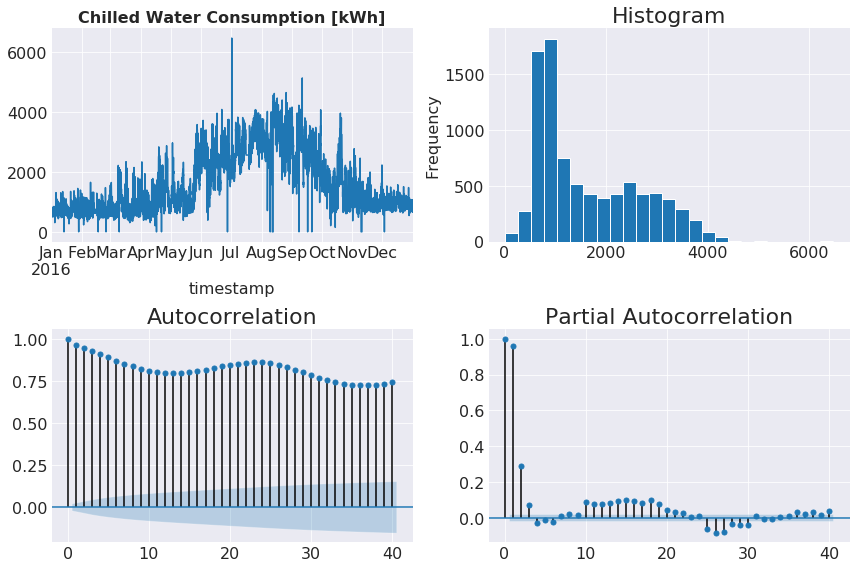

In [13]:
y = chw_consumption.meter_reading
vis.tsplot(y, 'Chilled Water Consumption [kWh]', lags=40)

### Stationarity

In [14]:
import testing_functions as testf

In [15]:
# vis.rolling_statistics(chw_consumption['meter_reading'])

## Features and labels
This capstone project will try to build a model that will effectively predict future energy consumption and air-temperature if the building operation doesn't change as a function of all the other eight parameters.

In [16]:
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [17]:
target_names = ['meter_reading']#, 'air_temperature']
shift_days = 1
shift_steps = shift_days * 24 # I wanted to shift the record by shift_steps hours.
df_targets = chw_consumption[target_names].shift(-shift_steps)
df_targets.head(3)

,meter_reading
timestamp,
2016-01-01 00:00:00,544.277
2016-01-01 01:00:00,581.708
2016-01-01 02:00:00,702.381


to check we successfully shifted by 24 hours, I took the 24 to 27 records from the original data

In [18]:
# check the raws from 24- 27
chw_consumption[target_names].iloc[24:27]

,meter_reading
timestamp,
2016-01-02 00:00:00,544.277
2016-01-02 01:00:00,581.708
2016-01-02 02:00:00,702.381


good! new we successfully shifted by 24 hours, let us split the data set into feature(x_data) and target(y_data). 

In [19]:
x_data = chw_consumption.values[0:-shift_steps]
print('    Feature Shape:', x_data.shape)

y_data = df_targets.values[:-shift_steps]
print('    Target Shape:', y_data.shape)

    Feature Shape: (8760, 8)
    Target Shape: (8760, 1)


now since we don't have enough training points, I elect to split 85% of the data as a training set and 15% of the data as a test set.

In [20]:
# These are the input-signals for the training- and test-sets:
num_data = len(x_data)
train_split = 0.85
num_train = int(train_split * num_data)
num_test = num_data - num_train
print('Training observations:', num_train)
print('Validation observations:', num_test)
x_train = x_data[0:num_train]
x_test  = x_data[num_train:]
print('Total observations:', (len(x_train) + len(x_test)))

# check the shape
print('X_train shape:', x_train.shape, 'and X_test shape:', x_test.shape)

Training observations: 7446
Validation observations: 1314
Total observations: 8760
X_train shape: (7446, 8) and X_test shape: (1314, 8)


In [21]:
date_train = chw_consumption.index[:num_train]
date_test = chw_consumption.index[num_train:-shift_steps]
data_train_train = chw_consumption.index[700:num_train]
print(len(date_train))
print(len(date_test))

7446
1314


the output signal shape will look like

In [22]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print('Total test observations:', (len(y_train) + len(y_test)))
print('y_train shape:', y_train.shape, 'and y_test shape', y_test.shape)

Total test observations: 8760
y_train shape: (7446, 1) and y_test shape (1314, 1)


In [23]:
num_x_signals = x_data.shape[1] # 8 
num_y_signals = y_data.shape[1] # 2
print('Number of input-signals:', num_x_signals, 'and shape:', x_train.shape )
print('Number of output-signals:', num_y_signals, 'and shape', y_train.shape)

Number of input-signals: 8 and shape: (7446, 8)
Number of output-signals: 1 and shape (7446, 1)


## MinMax data scaler

neural network like input variable to be small to make prediction, probably in the range of 0 - 1. So, let us use MinMax secret to satisfy the network architecture.

In [24]:
print('Min and Max x_train data')
print('    Min:', np.min(x_train))
print('    Max:', np.max(x_train))
x_scaler = MinMaxScaler() # feature_range=(0, 1)
x_scaled_train = x_scaler.fit_transform(x_train)
print('Min and Max x_train_scaled data')
print('    Min:', np.min(x_scaled_train))
print('    Max:', np.max(x_scaled_train))

Min and Max x_train data
    Min: -25.6
    Max: 6470.36
Min and Max x_train_scaled data
    Min: 0.0
    Max: 1.0


In [25]:
x_scaled_test = x_scaler.transform(x_test)
print('Min and Max x_test data')
print('    Min:', np.min(x_test))
print('    Max:', np.max(x_test))

# target MinMaxScaler
y_scaler = MinMaxScaler() # feature_range=(-1, 1)
y_scaled_train = y_scaler.fit_transform(y_train)
y_scaled_test = y_scaler.transform(y_test)
print('Min and Max y_test_scaled data')
print('    Min:', np.min(y_scaled_test))
print('    Max:', np.max(y_scaled_test))

Min and Max x_test data
    Min: -23.3
    Max: 2460.09
Min and Max y_test_scaled data
    Min: 0.0
    Max: 0.38020913828596864


In [26]:
print('shape of scaled training feature', x_scaled_train.shape)
print('shape of scaled training target', y_scaled_train.shape)
print('----------------------------------------')
print('shape of scaled test feature', x_scaled_test.shape)
print('shape of scaled test target', y_scaled_test.shape)

shape of scaled training feature (7446, 8)
shape of scaled training target (7446, 1)
----------------------------------------
shape of scaled test feature (1314, 8)
shape of scaled test target (1314, 1)


The data now has one long-time series with 8 input signals and 2 output signals

## Data Generator

Define the following function to create a 3D batch of shorter sub-sequences picked at random from the training-data.

In [27]:
# %load -r 92-117 helper_functions.py
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_scaled_train[idx:idx+sequence_length]
            y_batch[i] = y_scaled_train[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

The ***batch_generator()*** function will break the long-time series signal into small subsequences and create a batch so that we can use it to train the neural network.

Neural network requires a 3D array formated like:
```python
[samples, time steps, features]
```

In [28]:
batch_size = 64 # batch size of 32 is a good starting point, we can also try with 64, 128, and 256.
sequence_length = shift_steps 

# create the batch-generator
generator = batch_generator(batch_size, sequence_length)

# test the batch-generator to see if it works 
x_batch, y_batch = next(generator)
print('X_batch shape:', x_batch.shape)
print('y_batch shape:', y_batch.shape)

X_batch shape: (64, 24, 8)
y_batch shape: (64, 24, 1)


We get a batch output where we have a batch size of 64 sequences, each sequence has 24, and 8 input signals and 2 output signals. 

I create a validation dataset from the testing data

In [29]:
validation_data = (np.expand_dims(x_scaled_test, axis=0),
                   np.expand_dims(y_scaled_test, axis=0))

In [30]:
print('X_test_validation', validation_data[0].shape)
print('y_test_validation', validation_data[1].shape)

X_test_validation (1, 1314, 8)
y_test_validation (1, 1314, 1)


## Create the Recurrent Neural Network (RNN) 

In [31]:
# import keras 
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Input, Dense, Embedding, LSTM, Dropout
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                               TensorBoard, ReduceLROnPlateau, CSVLogger)

### Initalize the RNN
Now let us instantiate an RNN model

In [32]:
# clear a model
tf.keras.backend.clear_session()

In [33]:
# Initializing RNN 
chw_dropout_model = Sequential()

#### Adding the LSTM layers and some Dropout regularization

In [34]:
from keras import regularizers

Using TensorFlow backend.


In [35]:
# Adding the first LSTM layer and some Dropout regularisation
chw_dropout_model.add(LSTM(units=100,
                           dropout=0.2,
                           return_sequences=True,
                           input_shape=(None, num_x_signals,)))

In [36]:
# Adding the second LSTM layer and some Dropout regularisation
chw_dropout_model.add(LSTM(units=100,
                           return_sequences=True,
                           dropout=0.2)) # kernel_regularizer=regularizers.l2(0.01)

In [37]:
chw_dropout_model.add(Dense(num_y_signals,
                            activation='sigmoid'))

### Loss Function

In [38]:
warmup_steps = 50

load the loss_mse_warmup function below

In [39]:
# %load -r 41-63 supervised_learning.py

### Compile Model

In [40]:
optimizer = RMSprop(lr=1e-3)
# optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

In [41]:
chw_dropout_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
chw_dropout_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 100)         43600     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
dense (Dense)                (None, None, 1)           101       
Total params: 124,101
Trainable params: 124,101
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

In [42]:
path_checkpoint = 'weights/model_weights_chw_dropout.h5' # save the model in h5 format
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                     monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [43]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [44]:
callback_tensorboard = TensorBoard(log_dir='./logs/',
                                   histogram_freq=0,
                                   write_graph=False) #'./23_logs/'

In [45]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [46]:
csv_logger = CSVLogger('logs/chw_dropout_model.csv')

In [47]:
# create a callback list  
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr,
             csv_logger] # check the logger

### Fit the RNN to the training set 

In [48]:
%%time
chw_dropout_history = chw_dropout_model.fit_generator(generator=generator,
                                                      epochs=20,
                                                      steps_per_epoch=100,
                                                      validation_data=validation_data,
                                                      callbacks=callbacks
                                                      )

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 99/100 [============================>.] - ETA: 0s - loss: 0.0236 - mse: 0.0236
Epoch 00001: val_loss improved from inf to 0.00243, saving model to weights/model_weights_chw_dropout.h5
100/100 [==============================] - 19s 186ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0141 - mse: 0.0141
Epoch 00002: val_loss improved from 0.00243 to 0.00181, saving model to weights/model_weights_chw_dropout.h5
100/100 [==============================] - 9s 88ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0109 - mse: 0.0109
Epoch 00003: val_loss did not improve from 0.00181

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================]

In [49]:
# chw_baseline_model.save('weights/chw_baseline_model.h5')

In [50]:
# load the model
# lastew = load_model('weights/chw_baseline_model.h5')
# lastew.evaluate(x_sis, y_sis)

### Evaluate the model

In [51]:
# evaluate on the training set
print('X_scaled_train shape:', x_scaled_train.shape,
      'y_scaled_train shape:', y_scaled_train.shape)
x_sis = np.expand_dims(x_scaled_train, axis=0)
y_sis = np.expand_dims(y_scaled_train, axis=0)
print('X_scaled_train reshaped:', x_sis.shape,
      'y_scaled_train reshaped:', y_sis.shape)
chw_dropout_model.evaluate(x_sis, y_sis)

X_scaled_train shape: (7446, 8) y_scaled_train shape: (7446, 1)
X_scaled_train reshaped: (1, 7446, 8) y_scaled_train reshaped: (1, 7446, 1)
1/1 [==============================] - 13s 13s/sample - loss: 0.0107 - mse: 0.0107


[0.010675345547497272, 0.010675346]

In [52]:
# evaluate on the test set
chw_dropout_model.evaluate(validation_data[0], validation_data[1])
print('validation set should be a 3D arrray', 
      validation_data[0].shape, validation_data[1].shape)

1/1 [==============================] - 2s 2s/sample - loss: 0.0020 - mse: 0.0020
validation set should be a 3D arrray (1, 1314, 8) (1, 1314, 1)


In [53]:
# first_model = load_model('weights/first_model.h5')
# first_model.evaluate(validation_data[0], validation_data[1])

In [54]:
print(x_scaled_train.shape)
print(y_scaled_train.shape)
print('------------------')
print(x_scaled_test.shape)
print(y_scaled_test.shape)
type(x_scaled_train)

(7446, 8)
(7446, 1)
------------------
(1314, 8)
(1314, 1)


numpy.ndarray

In [55]:
# this is also a validation test
result = chw_dropout_model.evaluate(x=np.expand_dims(x_scaled_test, axis=0),
                        y=np.expand_dims(y_scaled_test, axis=0))
print("loss (test-set):", result)

1/1 [==============================] - 2s 2s/sample - loss: 0.0020 - mse: 0.0020
loss (test-set): [0.0019951374270021915, 0.0019951374]


In [56]:
# If you have several metrics you can use this instead.
# if False:
#     for res, metric in zip(result, model.metrics_names):
#         print("{0}: {1:.3e}".format(metric, res))

load plot comparision plot

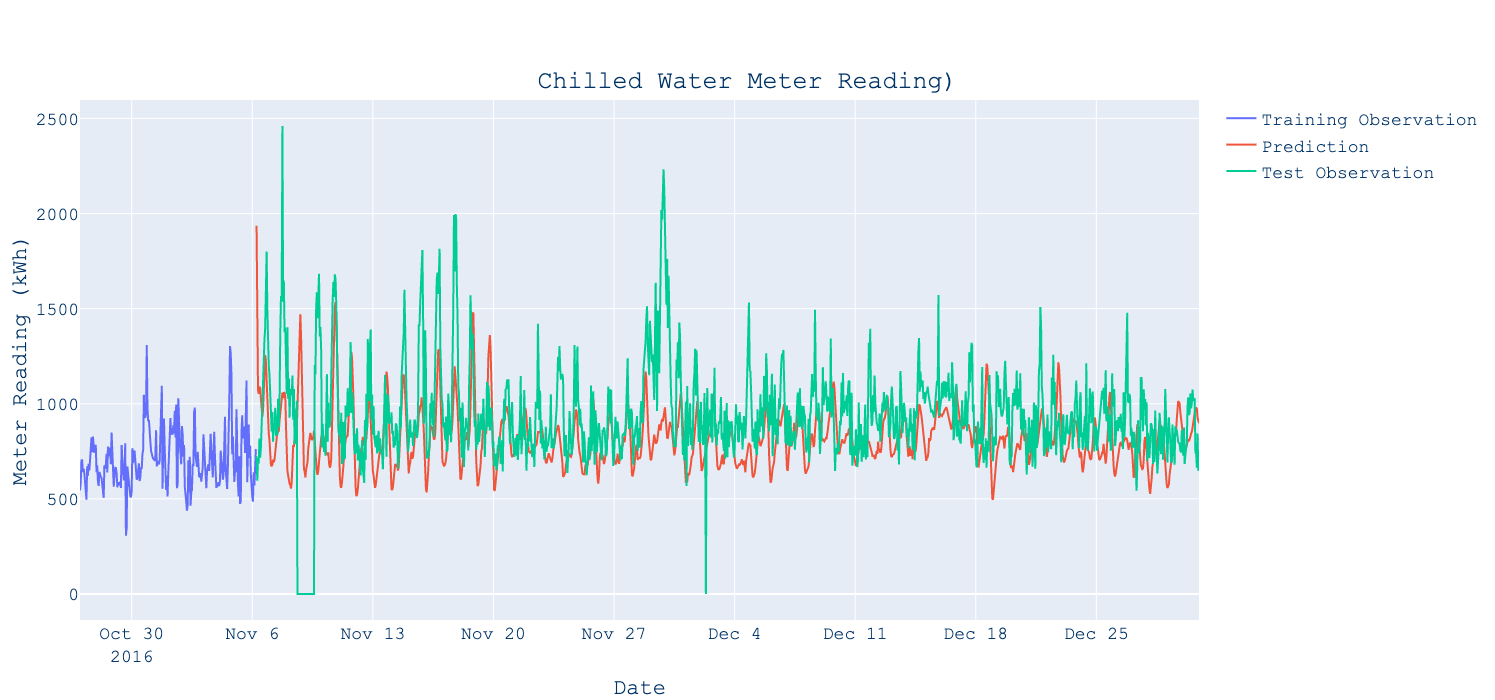

In [63]:
# prediction = model.predict_generator(test_generator)

x = np.expand_dims(x_scaled_test, axis=0)
y_pred = chw_dropout_model.predict(x)
y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])


y_train_reshaped = y_train.reshape((-1))
y_test_reshaped = y_test.reshape((-1))
y_pred_reshaped = y_pred_rescaled.reshape((-1))

trace1 = go.Scatter(
    x = chw_consumption.index[7200:num_train],
    y = y_train_reshaped,
    mode = 'lines',
    name = 'Training Observation'
)
trace2 = go.Scatter(
    x = date_test,
    y = y_pred_reshaped,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = y_test_reshaped,
    mode='lines',
    name = 'Test Observation'
)
layout = go.Layout(width=1400, height=700,
    title = {'text': "Chilled Water Meter Reading)", 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Meter Reading (kWh)", }
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.update_layout(font=dict(family="Courier New, monospace", size=18, color="#003366", )) # "#7f7f7f"
# fig.write_image('image/time_series_forcast_chw.png')
fig.show()

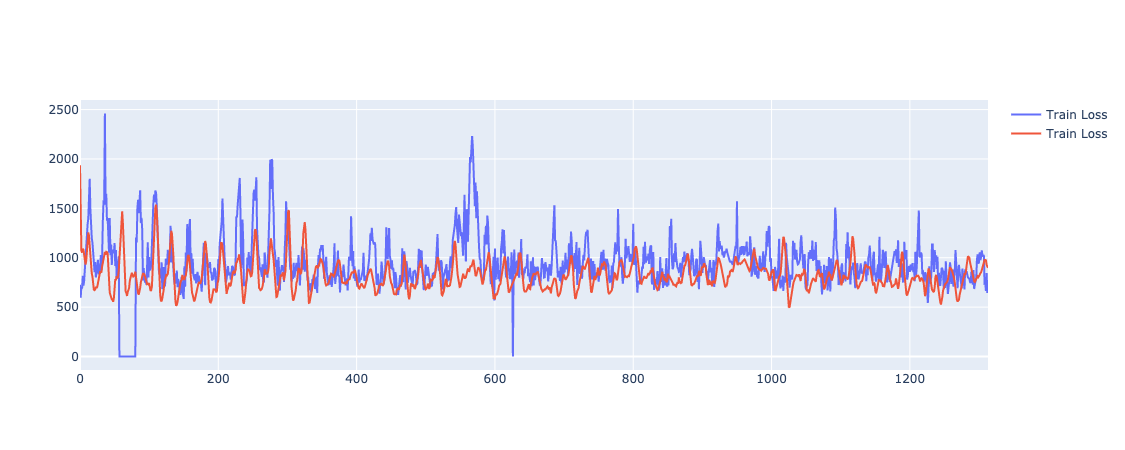

In [58]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=y_test_reshaped, name="Train Loss", mode='lines'))
fig.add_trace(go.Scatter(y=y_pred_reshaped, name="Train Loss", mode='lines'))

### Train vs Test loss

In [59]:
import visualization as vis

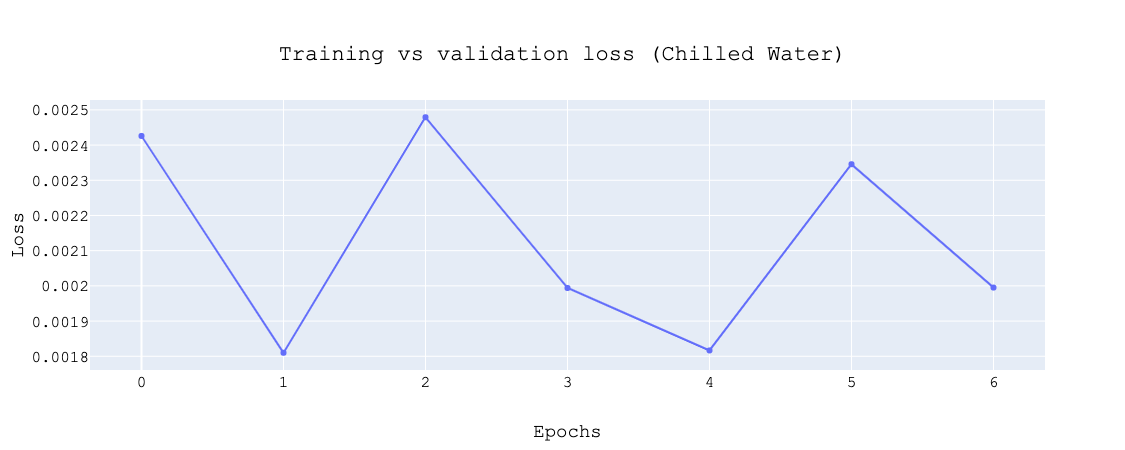

In [60]:
vis.plot_train_vs_val_loss(history=chw_dropout_history, a='Chilled Water')

## Performance Metric
The mean percentage error (MPE) is the computed average of percentage errors by which forecasts of a model differ from actual values of the quantity being forcast. 
The formula for the mean percentage error is

In [65]:
y_pred = chw_dropout_model.predict(np.expand_dims(x_scaled_test, axis=0))
# x = np.expand_dims(x, axis=0)
y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

In [66]:
# Mean Percent Error
mpe = np.sum((y_test-y_pred_rescaled)/y_test)/len(y_test)
mpe*100

-inf

In [61]:
# %load -r 43-101 visualization.py
def plot_comparison(start_idx,length=100, train=True, model=None):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_scaled_train
        y_true = y_train
    else:
        # Use test-data.
        x = x_scaled_test
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
#         plt.savefig('image/')

In [62]:
plot_comparison(start_idx=4000, length=1000, train=True, model=chw_dropout_model)

NameError: name 'plt' is not defined

### Comparison plot

#### For the training set

In [ ]:
plot_comparison(start_idx=4000, length=1000, train=True, model=chw_dropout_model)

#### For the test set

In [ ]:
plot_comparison(start_idx=1000, length=2000, train=False, model=chw_dropout_model)

In [71]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
# %load -r 145-181 helper_functions.py                
def calculate_model_accuracy_metrics(train=True, model=None):#, x_scaled_train=None, x_scaled_test=None, y_train=None, y_test=None):
    """
    Output model accuracy metrics, comparing predicted values
    to actual values.
    Arguments:
        boolan :
    Outputs:
        Forecast bias metrics, mean absolute error, mean squared error,
        and root mean squared error in the console
    """
    if train:
        # Use training-data.
        x = x_scaled_train
        y_true = y_train
        print('Traning data:')
    else:
        # Use test-data.
        x = x_scaled_test
        y_true = y_test
        print('Testing data:')
        
    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # Calculate mean absolute error, mean squared error and root mean squared error terms
    for signal in range(len(target_names)):
        
        signal_pred = y_pred_rescaled[:, signal]
        signal_true = y_true[:, signal]
        
        mae = mean_absolute_error(signal_true, signal_pred)
        mse = mean_squared_error(signal_true, signal_true)
        rmse = np.sqrt(mse)
        print('    Mean Absolute Error: %f' % mae)
        print('    Root Mean Squared Error: %f' % rmse)
        print('    --------------------------------')

In [ ]:
calculate_model_accuracy_metrics(train=True, model=chw_dropout_model)#, x_scaled_train=x_scaled_train, x_scaled_test=x_scaled_test, y_train=y_train, y_test=y_test)

In [67]:
def calculate_errors(train=True, model=None):
    
    if train:
        # Use training-data.
        x = x_scaled_train
        y_true = y_train
        print('Traning data:')
    else:
        # Use test-data.
        x = x_scaled_test
        y_true = y_test
        print('Testing data:')
    
    x = np.expand_dims(x, axis=0)

    y_pred = model.predict(x)
    
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    for signal in range(len(target_names)):
        signal_pred = y_pred_rescaled[:, signal]
        signal_true = y_true[:, signal]
        
        print('    Mean Absolute Error:', mean_absolute_error(signal_true, signal_pred))
        print('    Mean Absolute percent Error:', mean_absolute_error(signal_true, signal_pred)/np.mean(y_true))
        print('    Root Mean Squared Error:',np.sqrt(mean_squared_error(signal_true, signal_pred)))

In [68]:
# calculate_model_accuracy_metrics(train=True, model=chw_dropout_model)

In [69]:
# calculate_errors(train=True, model=chw_dropout_model)

In [72]:
calculate_errors(train=False, model=chw_dropout_model)

Testing data:
    Mean Absolute Error: 203.8612045640176
    Mean Absolute percent Error: 0.21690448716246624
    Root Mean Squared Error: 289.01131851853313


In [ ]:
# plot train vs validation loss
hf.plot_train_vs_val_loss(history=chw_dropout_history)

In [ ]:
chw_dropout_history.histor

In [ ]:
# plot training curve for mae 
plt.plot(chw_dropout_history.history['mae'])
plt.plot(chw_dropout_history.history['val_mae'])
plt.title('mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
# plot training curve for rmse
plt.plot(chw_dropout_history.history['rmse'])
plt.plot(chw_dropout_history.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# plot model accuracy vs validation 
hf.plot_train_vs_val_accuracy(history=chw_dropout_history)

In [ ]:
def plot_train_vs_val_accuracy(history=None):
    """
    plot model accuracy, comparing training and testing accuracies.
    Arguments:
        history: model history 
    Outputs:
        accuracy plot 
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=chw_consumption.index, y=y_axis,
                         name="Original", line_color='blue'))
#     plt.figure(figsize=(10,5))
    plt.plot(history.history['acc'], label='Train Accuracy')
    plt.plot(history.history['val_acc'], label='Test Accuracy')
    plt.title('Model train vs validation accuracy', fontsize=20)
    plt.ylabel('accuracy', fontsize=16)
    plt.xlabel('epochs', fontsize=16)
    plt.xticks(fontsize=12), plt.yticks(fontsize=12)
    plt.legend(loc='upper right', fontsize=14)
    sns.set_context("paper", font_scale=1.3)
    sns.set_style('white')
    plt.show();

## One layer with dropout

In [ ]:
# clear a model
tf.keras.backend.clear_session()

In [ ]:
# Initializing RNN 
chw_onelayer_model = Sequential()

### Adding LSTM layers and Dropout regularization

In [ ]:
# Adding the first LSTM layer and some Dropout regularisation
chw_onelayer_model.add(LSTM(units=100, return_sequences=True, #kernel_regularizer=regularizers.l2(0.01),
#                            activity_regularizer=regularizers.l1(0.01),
                           input_shape=(None, num_x_signals,)))
chw_onelayer_model.add(Dropout(0.2))

In [ ]:
chw_onelayer_model.add(Dense(num_y_signals, activation='sigmoid', #kernel_regularizer=regularizers.l2(0.01),
#                 activity_regularizer=regularizers.l1(0.01)
                           ))

In [ ]:
# model.compile(loss=loss_mse_warmup, optimizer=optimizer, metrics=['acc'])
chw_onelayer_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
chw_onelayer_model.summary()

### Fitting the model

In [ ]:
csv_logger = CSVLogger('logs/chw_onelayer_model.csv')

In [ ]:
path_checkpoint = 'weights/model_weights_chw_onelayer.h5'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                     monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [ ]:
# callback lists 
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr,
             csv_logger] # check the logger

In [ ]:
%%time
chw_onelayer_history = chw_onelayer_model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=50, #100,
                    validation_data=validation_data,
                    callbacks=callbacks)

### Evaluating the model

In [ ]:
# test set
chw_onelayer_model.evaluate(validation_data[0], validation_data[1])

In [ ]:
# train set
chw_onelayer_model.evaluate(x_batch, y_batch)

# Daily

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

In [ ]:
generator_original = batch_generator(batch_size, sequence_length)

x_obatch, y_obatch = next(generator)
print('X_batch shape:', x_obatch.shape)
print('y_batch shape:', y_obatch.shape)

In [ ]:
validation_odata = (np.expand_dims(x_test, axis=0),
                   np.expand_dims(y_test, axis=0))

In [ ]:
print('X_test_validation', validation_data[0].shape)
print('y_test_validation', validation_data[1].shape)

In [ ]:
# clear a model
tf.keras.backend.clear_session()

In [ ]:
# Initializing RNN 
chw_original_model = Sequential()

In [ ]:
# Adding the first LSTM layer and some Dropout regularisation
chw_original_model.add(LSTM(units=100,
                           return_sequences=True,
                           input_shape=(None, num_x_signals,)))
chw_original_model.add(Dropout(0.4))

In [ ]:
chw_original_model.add(Dense(num_y_signals, activation='sigmoid'))

In [ ]:
chw_original_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
chw_original_model.summary()

In [ ]:
csv_logger = CSVLogger('logs/chw_original_model.csv')

In [ ]:
path_checkpoint = 'weights/model_weights_chw_original.h5'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                     monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [ ]:
# callback lists 
callbacks_o = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr,
             csv_logger] # check the logger

In [ ]:
%%time
chw_onelayer_history = chw_original_model.fit_generator(generator=generator_original,
                    epochs=20,
                    steps_per_epoch=50, #100,
                    validation_data=validation_odata,
                    callbacks=callbacks_o)

In [ ]:
# test set
chw_original_model.evaluate(validation_odata[0], validation_odata[1])

In [ ]:
# train set
chw_original_model.evaluate(x_obatch, y_obatch)